<center>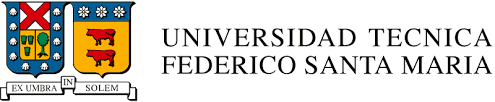</center>



<hr style="height:2px;border:none"/>
<h1 align='center'> INF-577 Redes Neuronales Artificiales 2022-2 </h1>

<H3 align='center'> Tarea Guiada I  </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Manipulaciones de datos con pandas y numpy
* Imputación de datos y preprocesamientos
* Redes Densas Feed Forward
* Regularización y Dropout
* Vanishing Gradient
* Learn Rate Decay
* Optimizadores

<hr style="height:2px;border:none"/>

## 1 - Redes Feed Forward para predicción de diabetes.

## A) Carga de datos y primeros análisis
Para la carga de datos se utiliza la API de Kaggle desde Google Colab para realizar este procedimiento se sigue la guía del siguiente [link](https://galhever.medium.com/how-to-import-data-from-kaggle-to-google-colab-8160caa11e2.)

In [1]:
# Library installation
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Upload file api key of kaggle 
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yerielpaz","key":"eb3031dff19821bfb83c83135987e326"}'}

In [3]:
# Api key file management and permissions 
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset 
!kaggle datasets download -d uciml/pima-indians-diabetes-database

# File extraction 
import zipfile
with zipfile.ZipFile('/content/pima-indians-diabetes-database.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

  0% 0.00/8.91k [00:00<?, ?B/s]
100% 8.91k/8.91k [00:00<00:00, 4.29MB/s]


Luego de descomprimir el archivo descargado  se cargan los datos en un *Dataframe* como muestra el código de la celda siguiente. Además se realiza Exploratory Data Analysis (EDA).

In [4]:
import pandas as pd

df = pd.read_csv("diabetes.csv", encoding = 'utf_8')
df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


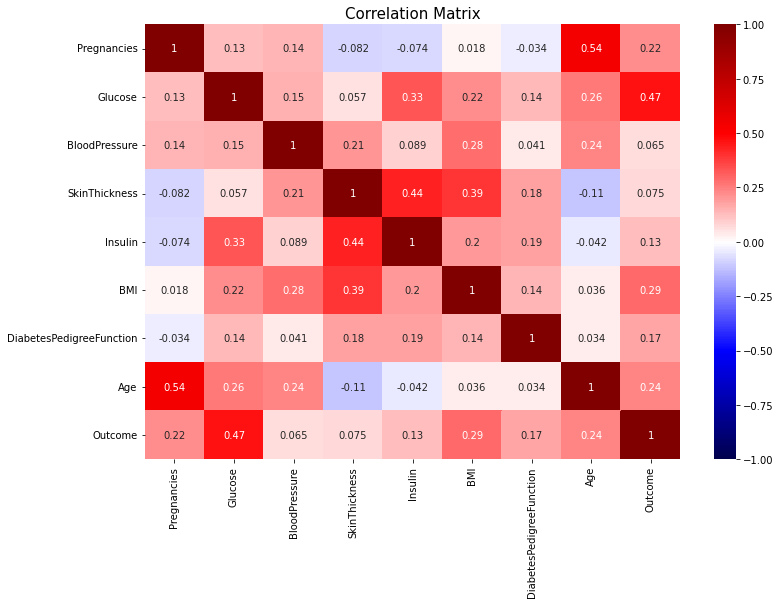

In [7]:
# Function to display the correlation matrix in a heat map
import seaborn as sns
import matplotlib.pyplot as plt

def plot_corr_matrix(data,features=None,annot=True,s=(12,8)):
    fig= plt.figure(figsize=s)
    ax= fig.add_subplot(111)
    if features is None:
        corr = data.corr()
    else:
        corr = data[features].corr()
    ax= sns.heatmap(corr,annot=annot,
        xticklabels=corr.columns,
    yticklabels=corr.columns, cmap="seismic",vmin=-1,vmax=1)
    plt.title("Correlation Matrix", fontsize = 15)
    plt.show()

plot_corr_matrix(df)

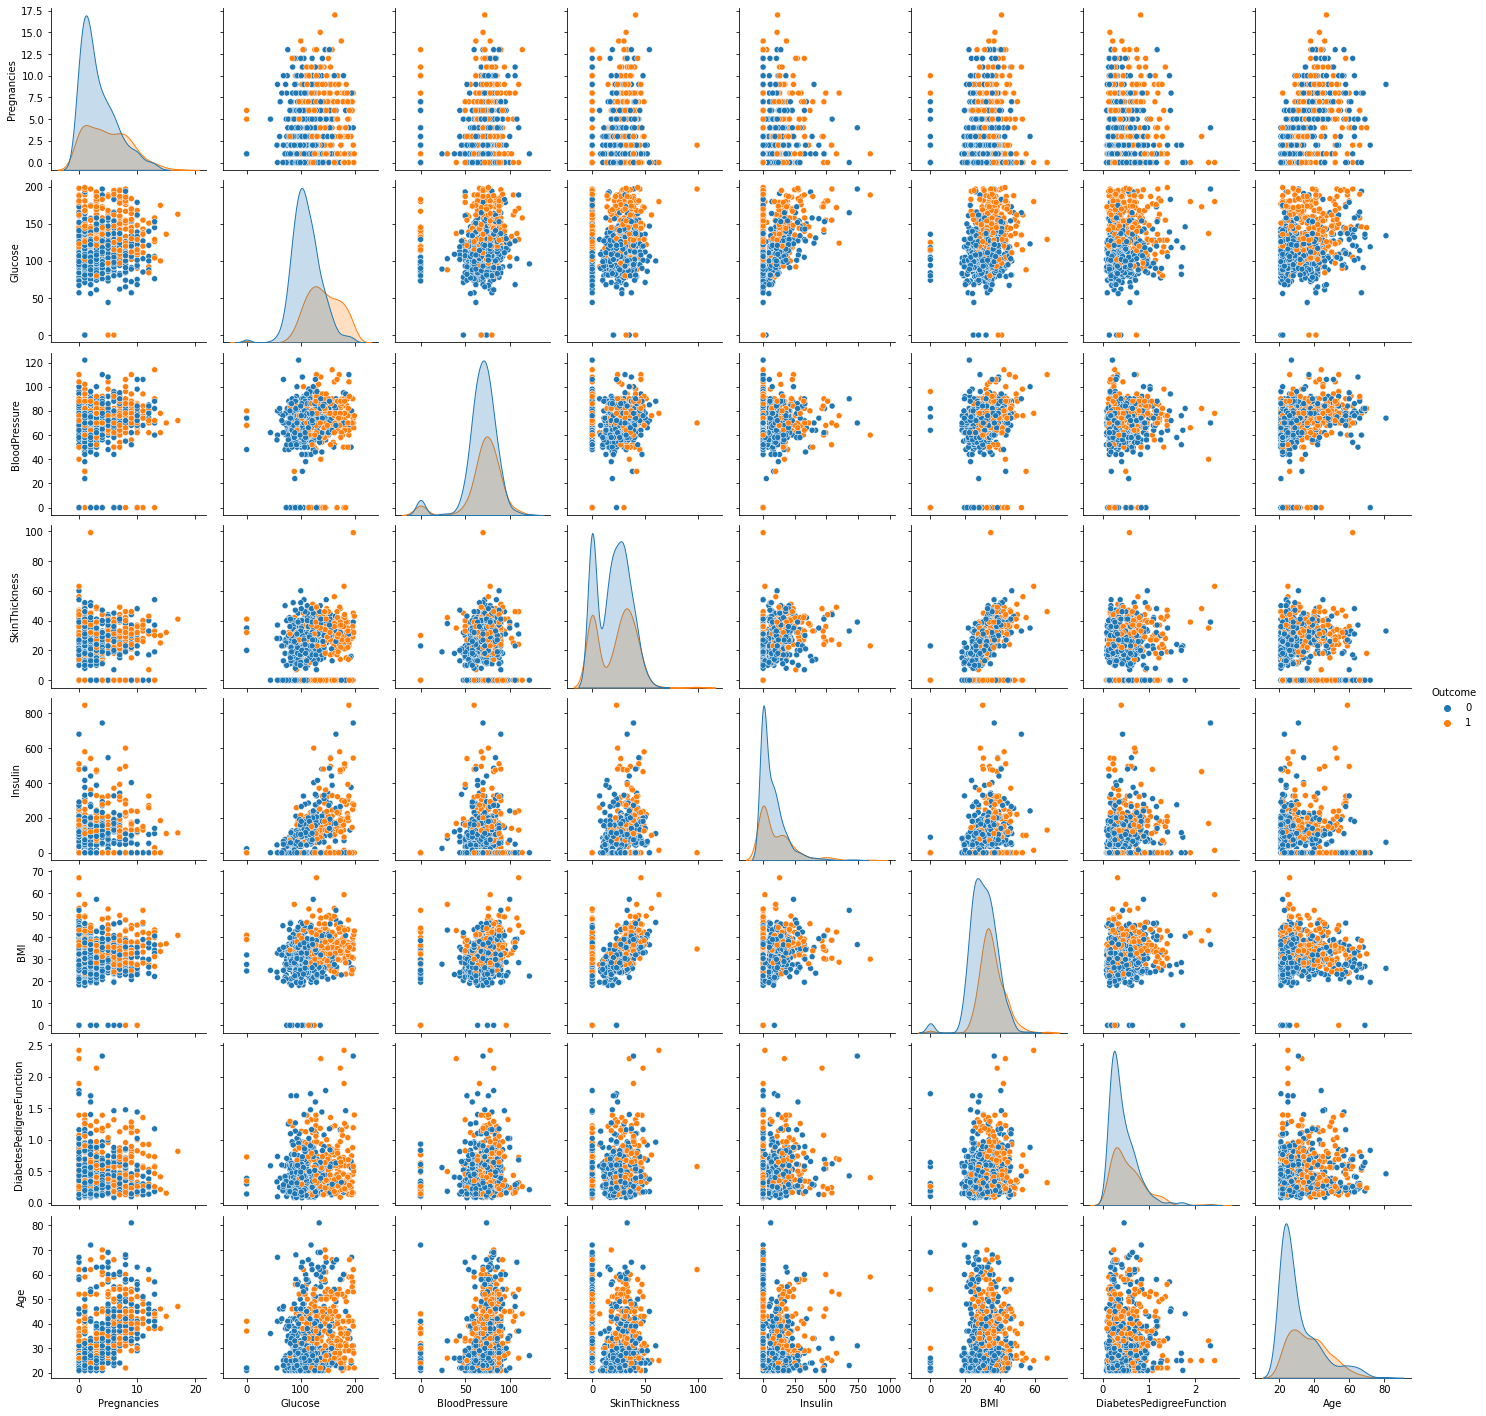

In [8]:
# EDA with all dataset
sns.pairplot(df, hue ='Outcome')

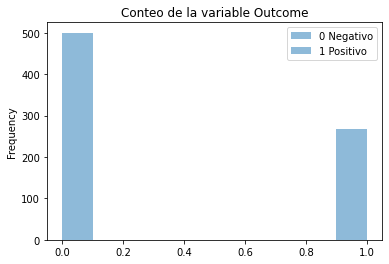

In [9]:
# Show balance of target label
plt.title("Conteo de la variable Outcome")
df['Outcome'].plot.hist(bins=10, alpha=0.5)
plt.legend(['0 Negativo','1 Positivo'])
plt.show()

- Luego del EDA se observa que no existe datos faltantes dentro del dataset. Pero realizando una exploración de las features del dataset se puede apreciar que los datos están imputados utilizando ceros ya que hay columnas como *Glucose, BloodPressure, SkinThickness, Insulin, BMI* toma como valor minimo el cero, cosa que no tiene sentido en el mundo real dado a que esto implica que un paciente se encuentra muerto. Esto hace que la información que entrega el método *describe()* no se del todo correcta ya que las medidas de tendencia central se ven afectados por estos outliers

- La variable Outcome es un muy buen candidato a ser el target para el problema dado a que presenta una alta correlación con el resto del dataset, lo que implica que la dispersión de los datos no es alta. Ademas existen pares de variables en donde los datos son separables tal como se observa en los gráficos de *Age vs Glucose* o *BloodPressure vs Glucose* generados con seaborn

<center>


|                          |   Rango Noramal  | Ref  |
|:------------------------:|:----------------:|:----:|
|          Glucose         | 80 - 120 [mg/dl] | [link](https://diabeteswalls.blogspot.com/2019/08/niveles-de-glucosa-en-sangre-diabetes.html)      |
|  BloodPressure sistolica |     90 - 120     | [link](https://www.dietdoctor.com/es/presion-arterial/normal)    |
| BloodPressure diastolica |      60 - 80     | [link](https://www.dietdoctor.com/es/presion-arterial/normal)  |
|       SkinThickness      |   0.05 - 5 [mm]  | [link](https://www.eucerin.com.mx/acerca-de-la-piel/conocimientos-basicos-sobre-la-piel/estructura-y-funcion-de-la-piel)        |
|          Insulin         | 60 - 100 [mg/dl] | [link](https://dtc.ucsf.edu/es/tipos-de-diabetes/diabetes-tipo-2/tratamiento-de-la-diabetes-tipo-2/medicamentos-y-terapias-2/prescripcion-de-insulina-para-diabetes-tipo-2/informacion-basica-sobre-la-insulina/)     |
|            BMI           |    18.5 - 24.9   |  [link](https://www.cdc.gov/healthyweight/spanish/assessing/index.html)    |


</center>

## B) Train Test Split

El dataset se separa en en los conjuntos de entrenamiento, validación y test y estandarizar los datos. Para realizar esta tarea se utiliza *sklearn.model_selection*. En donde los $X$  representar las features e  $Y$ el target. La separación del dataset se realiza considerando un  70%  de ellos para entrenamiento, un  20%  para validación y un  10%  para test.

In [10]:
from sklearn.model_selection import train_test_split

# Separating X and y 
y = df.Outcome
X = df.drop(columns=['Outcome'])

# Separating train and test
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.1, random_state=19)

# Separating train and validation
X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, test_size=0.2, random_state=19)

print(f' df    :{df.shape[0]}\n X_tr  :{X_tr.shape[0]}\n X_val :{X_val.shape[0]}\n X_test  :{X_test.shape[0]}')

 df    :768
 X_tr  :552
 X_val :139
 X_test  :77


Con la separación del dataset ahora se consta con un conjunto con el cual entrenar a una máquina de aprendizaje/red neuronal y genera diferentes modelos de los cuales se escogerá uno a partir del los datos de validación y con los datos se test se verificara el rendimiento del modelo escogido lo mas importante de esta separación es tener en cuanta que los datos de test nunca se usaran para generar un modelo si no que solo para medir el rendimiento de este

## C) Valores faltantes e imputación
Tomando en cuenta solamente el conjunto de entrenamiento, se consideran los valores imputados con 0 y se reemplazan por `NaN`, para esto utiliza el método `replace`. Ademas se cuentan cuantos datos faltantes hay por cada atributo y se grafíca. 

Se crean 3 conjuntos de entrenamiento nuevos a partir del resultado de reemplazar con `NaN`:

1.   Conserve el conjunto de entrenamiento original intacto: $X_o$
2.   Reemplace los valores faltantes de cada columna por la media de estos: $X_1$
3.   Reemplace los valores faltantes de cada columna por la mediana de estos: $X_2$
4.   Reemplace los valores faltantes de cada columna utilizando el método MICE: $X_3$

In [11]:
import numpy as np

X_tr[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = X_tr[['Glucose',
'BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

X_tr.isna().sum()

Pregnancies                   0
Glucose                       4
BloodPressure                24
SkinThickness               158
Insulin                     266
BMI                           6
DiabetesPedigreeFunction      0
Age                           0
dtype: int64

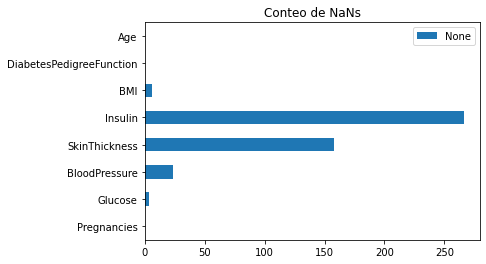

In [12]:
plt.title("Conteo de NaNs")
X_tr.isna().sum().plot(kind='barh')
plt.legend()
plt.show()

In [13]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from copy import deepcopy

# Simple imputer with mean or median
def Imputer(df, strategy_='mean'):
    df_ = deepcopy(df)
    imputer = SimpleImputer(strategy=strategy_)
    return pd.DataFrame(imputer.fit_transform(df_), columns=df_.columns)

def miceImputer(df,):
    df_ = deepcopy(df)
    imputer = IterativeImputer(max_iter=10, random_state=19, sample_posterior=True)
    return pd.DataFrame(imputer.fit_transform(df_), columns=df_.columns)

X = {'X_tr_0': deepcopy(X_tr.reset_index().drop('index',axis=1).replace(np.NaN,0)),
    'X_tr_1': Imputer(X_tr),
    'X_tr_2': Imputer(X_tr,'median'),
    'X_tr_3': miceImputer(X_tr)}

*   ¿Qué es la imputación de datos?

La imputación es la sustitución de valores no informados en una observación por otros, es decir, es estimar el valor de un dato faltante bien sea usando la información de los registro vecinos o la información de las columnas o variables que sean parte de nuestro set de datos. 

*   ¿Cuáles son las ventajas y desventajas de los 3 métodos recién utilizados versus sin imputar ($X_o$)?

La imputación siempre (por meadia o mediana) tienen un gran problema y es que para reemplazar el dato faltante se fían de una única estimación.

MICE en la práctica no cambia la distribución obtenida sin embargo tampoco es perfecto porque para poderlo utilizar se debe garantizar que las variables están relacionadas linealmente de no ser así se debe usar modelos estadísticos más sofisticados. 

*   ¿Qué se necesita para ejecutar cada uno de los 3 métodos de imputación de datos?

La imputación por la media o la mediana es la más sencilla de todas simplemente se toman los valores conocidos en la variable donde están los datos faltantes se calculan la media o la mediana y se reemplazan estos datos faltantes con cualquiera de estos dos valores.

Con MICE de forma interactiva se harán progresivamente cada vez mejores estimaciones de los datos faltantes inicialmente la primera estimación no es muy buena y se hace con la imputación por la media pero en los pasos restantes se aplica una regresión lineal entre pares consecutivos de columnas y el procedimiento se repite una y otra vez hasta completar un número predefinido de iteraciones, la idea es que progresivamente las estimaciones sean cada vez más precisas y se acerquen más al valor real.

*   ¿Qué puede decir de los conjuntos resultantes?¿Resuelven el problema de los datos faltantes?

Si los tres mecanismos resuelven el problema de datos faltantes el problema está en los dos primeros mecanismos (imputación por media y mediana) ya que la variable Insulin presenta muchos datos faltantes y estos mecanismos rompen la distribución de los datos originales al momento de que se tienen muchos datos perdidos.


## D) Estandarización

`Nota:` A menos que se indique explícitamente lo contrario, en esta y las siguientes secciones se realizan todos los procedimientos considerando como conjunto de entrenamiento cada $X \in \{X_o, X_1, X_2, X_3\}$ obtenido en la imputación anterior.

Se procede a ajuste los scalers con los datos de entrenamiento y se transforman los datos para cada conjunto obtenido en la seccion anterior.



In [14]:
from sklearn.preprocessing import StandardScaler

def scaler(X_tr, X_val, X_test):
    scaler_ = StandardScaler()
    scaler_.fit(X_tr)
    return (pd.DataFrame(scaler_.transform(X_tr), columns=X_tr.columns), 
            pd.DataFrame(scaler_.transform(X_val), columns=X_val.columns),
            pd.DataFrame(scaler_.transform(X_test), columns=X_test.columns)
    )

i=0
for key, item in list(X.items()):
    x_tr, x_val, x_test = scaler(item,X_val,X_test)
    X.update({key:x_tr})
    
    key = f'X_val_{i}'
    X.update({key:x_val})
    
    key = f'X_test_{i}'
    X.update({key:x_test})
    i+=1

- ¿Qué operación matemática realiza `StandarScaler` al momento de tranformar los datos? 

La idea detrás de StandardScaler es que transformará los datos de tal manera que su distribución tendrá un valor medio 0 y una desviación estándar de 1.
En el caso de los datos multivariados, esto se hace por características (en otras palabras, independientemente para cada columna de los datos).

Dada la distribución de los datos, a cada valor del conjunto de datos se le restará el valor medio y se dividirá por la desviación estándar de todo el conjunto de datos (o característica en el caso multivariante).

Standardization: $ z = x − \mu\sigma$

with mean: $\mu = \frac{1}{N}Σ_{i=1}^{N}X_i$

and standard deviation: $ \sigma = \sqrt{\frac{1}{N} \Sigma_{i=1}^{N}(x_i - \mu)^2}$

- ¿Por qué debemos transformar los datos de validación y de test con el _scaler_ ajustado a los datos de entrenamiento? 

La razón es que queremos fingir que los datos de prueba son "datos nuevos, no vistos". Utilizamos el conjunto de datos de prueba para obtener una buena estimación de cómo se comporta nuestro modelo con cualquier dato nuevo.

Otra forma de decir lo mismo es si estandarizamos nuestro conjunto de datos de entrenamiento, necesitamos mantener los parámetros (media y desviación estándar para cada característica). Entonces, usaríamos estos parámetros para transformar nuestros datos de prueba y cualquier dato futuro más adelante.

## E) Red Neuronal

Se construye una red neuronal. Para esto se utiliza la biblioteca keras que permite crear, compilar y entrenar los modelos de manera simple. 

La arquitectura corresponde a la de una red de una capa oculta con $256$ neuronas, activación ReLu y una función de perdida que corresponde a _Binary Cross Entropy_, junto con el optimizador Gradiente Descendente Estocástico (SDG) con un _Learn Rate_ de 0.002. Y su entrenamiento sera durante 20 _epochs_.


- ¿Porqué se ocupa esta función de pérdida?

Se utiliza esta función de perdida ya que el problema corresponde a un problema de clasificación binaria

- ¿Qué función de activación se utiliza para la capa de salida en este tipo de problemas?

Los problemas de clasificación pueden aprovechar la condición de que las clases sean mutuamente excluyentes, por lo tanto usar la funcion softmax permite que los resultados de la red sumen uno lo que permite dar una interpretacion probabilistica al resultados de la red.

- ¿Cuántas neuronas para la capa de salida?.

Como la etiqueta target corresponde a de caracter binario (0/1) solo se require de una neurona a la salida.

In [15]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

print(f'Version {tf.__version__} of tf with keras is being used\n')

OUTPUT_SIZE = 1

model = Sequential()
model.add(Dense(256, 
                input_dim=8, 
                activation='relu'))

model.add(Dense(
    OUTPUT_SIZE, 
    activation='softmax'))


model.summary()

Version 2.8.2 of tf with keras is being used

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2304      
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________________


 - ¿Cómo a partir de la dimensión del Input y el número de neuronas obtenemos ese número de parámetros?

 Para la primera capa se tiene 8 features y 256 neuronas por lo tanto la cantidad de parametros esta dada por $(8*256)\ [weights] + 256\ [bias] = 2304\ [params] $

 Para la capa de salida solo se tiene una neurona por lo cual el calculo de parametro se esta dado por $(256*1)\ [weights] + 1\ [bias] = 257\ [params] $

In [16]:
def plotErrors(histories, numEpochs = 20, name=''):
    
    xAxis = range(1,numEpochs+1)
    fig, ax = plt.subplots(4,1,figsize=(10,10))

    for i in range(4):
        yLossTrain = histories[i].history['loss']
        yLossVal = histories[i].history['val_loss']
        ax[i].plot(xAxis,yLossTrain, color='red', marker='o', label='Train Loss')
        ax[i].plot(xAxis,yLossVal, color='blue', marker='o', label='Val Loss')
        ax[i].title.set_text(f' train v/s validation error for X_tr_{i} {name}')
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Error loss') 
        ax[i].legend(loc="upper right")
        plt.tight_layout()

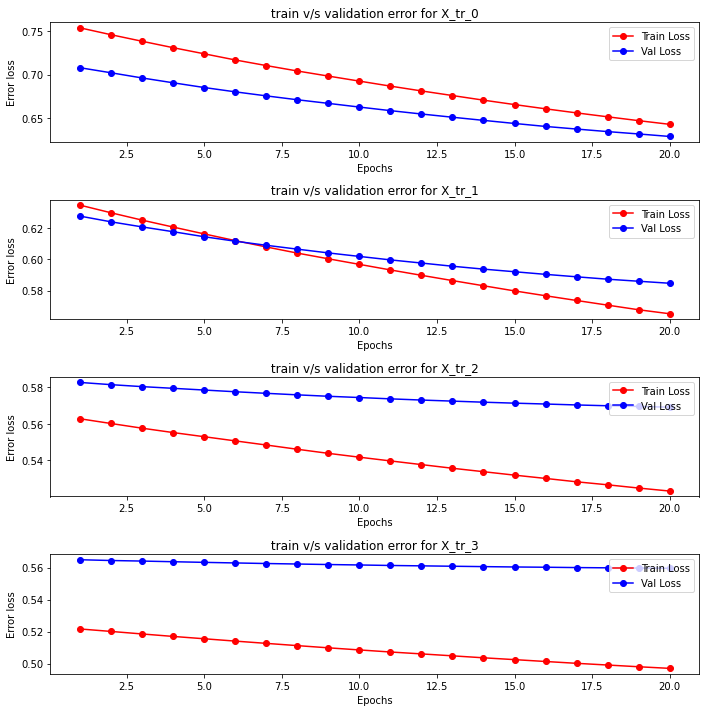

In [17]:
learningRate = 2e-3

model.compile(tf.keras.optimizers.SGD(learning_rate=learningRate),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = tf.keras.metrics.BinaryAccuracy())

histories = []
for i in range(4):
    val = f'X_val_{i}'    
    tr = f'X_tr_{i}'
    histories.append(model.fit(X[tr], y_tr, epochs=20, 
                        validation_data=(X[val],y_val),
                        verbose = 0))
    
plotErrors(histories)

-	Para X_tr_0 se pude apreciar que la curva de validación recibe un mejor desempeño que la de entrenamiento lo que refleja que el conjunto de datos de validación es más fácil de predecir que el de entrenamiento. Una explicación podría ser que los datos de validación son escasos, pero están ampliamente representados por el conjunto de datos de entrenamiento. De todos modos, esto significa que el conjunto de datos de validación no representa el conjunto de datos de entrenamiento, por lo que hay un problema de representatividad.

-	Para X_tr_1, X_tr_2, X_tr_3 se aprecia una amplia diferencia entre las curvas de validación y entrenamiento se pude decir que el modelo presenta underfiting dado a la brecha existente entre las curvas, pero este análisis es apresurado dado a que se realizó un entrenamiento durante solo 20 epochs es posible que el modelo se ajuste bien si el entrenamiento fuera más largo dado a la tendencia descendiente que presenta la curva del loss de validación


### Training with 2e-4

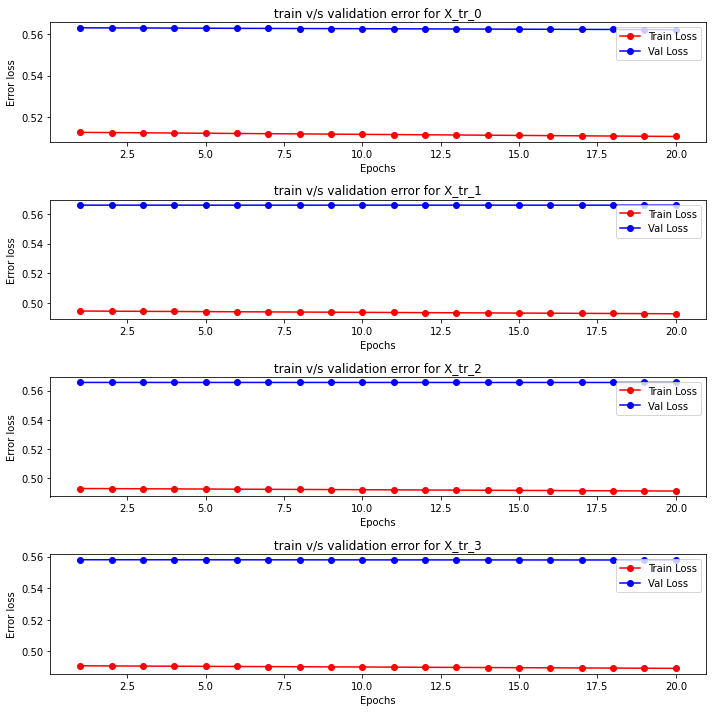

In [18]:
learningRate = 2e-4

model.compile(tf.keras.optimizers.SGD(learning_rate=learningRate),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = tf.keras.metrics.BinaryAccuracy())

histories = []
for i in range(4):
    val = f'X_val_{i}'    
    tr = f'X_tr_{i}'
    histories.append(model.fit(X[tr], y_tr, epochs=20, 
                        validation_data=(X[val],y_val),
                        verbose = 0))
    
plotErrors(histories)

-	Para todos los dataset de entrenamiento el modelo presenta un gran brecha entre las curvas de loss lo que implica que el modelo presenta underfiting. A diferencia de la sección anterior las curvas no presenta una tendencia de mejora por lo que un entrenamiento mas largo no solo solucionaría el problema

### Training with 2e-1



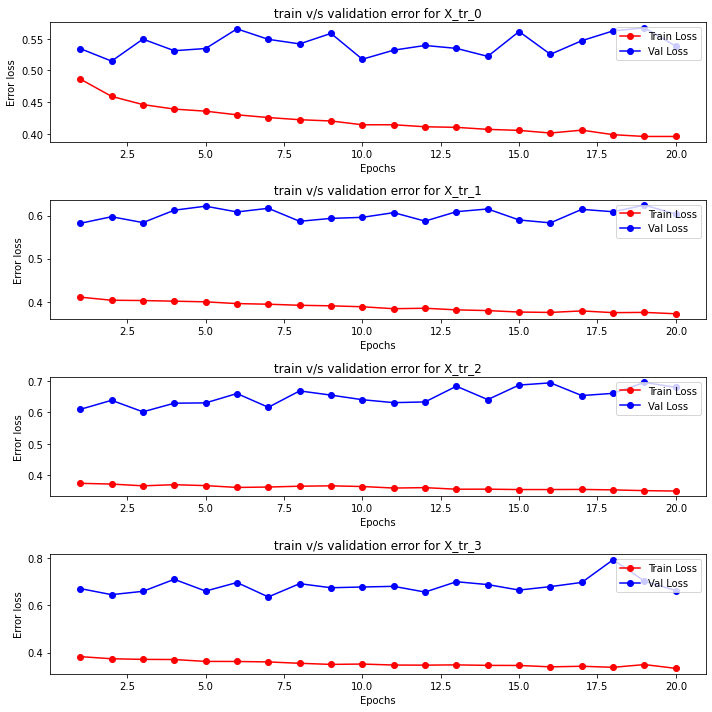

In [19]:
learningRate = 2e-1

model.compile(tf.keras.optimizers.SGD(learning_rate=learningRate),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = tf.keras.metrics.BinaryAccuracy())

histories = []
for i in range(4):
    val = f'X_val_{i}'    
    tr = f'X_tr_{i}'
    histories.append(model.fit(X[tr], y_tr, epochs=20, 
                        validation_data=(X[val],y_val),
                        verbose = 0))
    
plotErrors(histories)

-	Para todos los dataset de entrenamiento las curva de validación es sumamente irregular en su comportamiento y presenta una tendencia creciente por lo que se podría sospechar de un posible caso de overfiting, es importante mencionar que este análisis solo se realizado con un entrenamiento de 20 epochs.

## F) Activación y regularizadores l1 y l2
Se explorar distintas funciones de activación y de regularización. En ambos casos se entrena la misma red entrenada anteriormente utilizando gradiente descendente estocástico con _learn rate_ $\leq 2e-3$. 

* Las funciones de activación a explorar son: tangente hiperbólica, _Leaky ReLu_, sigmoidea y lineal.




In [20]:
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.regularizers import l1, l2

def modelANN(function='leakyRelu', regularizer = None, rate=1e-3, bothLayer=False):

    if function == 'leakyRelu':
        if regularizer == 'l2':
            if bothLayer:
                model = Sequential()
                model.add(Dense(256,input_dim=8,activation=LeakyReLU(),activity_regularizer=l2(rate)))
                model.add(Dense(1,activation='softmax',activity_regularizer=l2(rate)))
                return model
            
            model = Sequential()
            model.add(Dense(256,input_dim=8,activation=LeakyReLU()))
            model.add(Dense(1,activation='softmax',activity_regularizer=l2(rate)))
            return model
                
        elif regularizer == 'l1':
            if bothLayer:
                model = Sequential()
                model.add(Dense(256,input_dim=8,activation=LeakyReLU(),activity_regularizer=l1(rate)))
                model.add(Dense(1,activation='softmax',activity_regularizer=l1(rate)))
                return model
            
            model = Sequential()
            model.add(Dense(256,input_dim=8,activation=LeakyReLU()))
            model.add(Dense(1,activation='softmax',activity_regularizer=l1(rate)))
            return model

        else:
            model = Sequential()
            model.add(Dense(256,input_dim=8,activation=LeakyReLU()))
            model.add(Dense(1,activation='softmax'))
            return model
    
    else:
        if regularizer == 'l2':
            if bothLayer:
                model = Sequential()
                model.add(Dense(256,input_dim=8,activation=function,activity_regularizer=l2(rate)))
                model.add(Dense(1,activation='softmax',activity_regularizer=l2(rate)))
                return model
            
            model = Sequential()
            model.add(Dense(256,input_dim=8,activation=function))
            model.add(Dense(1,activation='softmax',activity_regularizer=l2(rate)))
            return model
                
        elif regularizer == 'l1':
            if bothLayer:
                model = Sequential()
                model.add(Dense(256,input_dim=8,activation=function,activity_regularizer=l1(rate)))
                model.add(Dense(1,activation='softmax',activity_regularizer=l1(rate)))
                return model
            
            model = Sequential()
            model.add(Dense(256,input_dim=8,activation=function))
            model.add(Dense(1,activation='softmax',activity_regularizer=l1(rate)))
            return model

        else:
            model = Sequential()
            model.add(Dense(256,input_dim=8,activation=function))
            model.add(Dense(1,activation='softmax'))
            return model

### Verificar la mejor función de activación

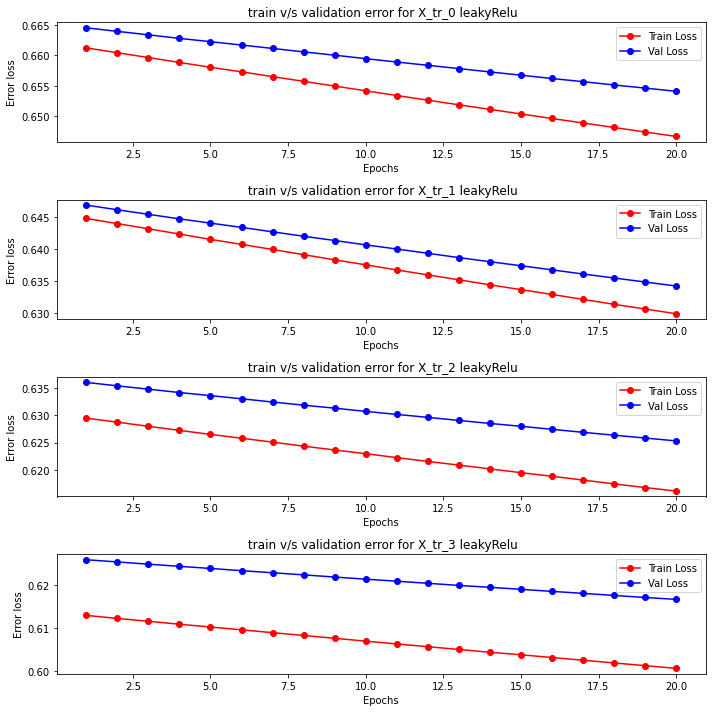

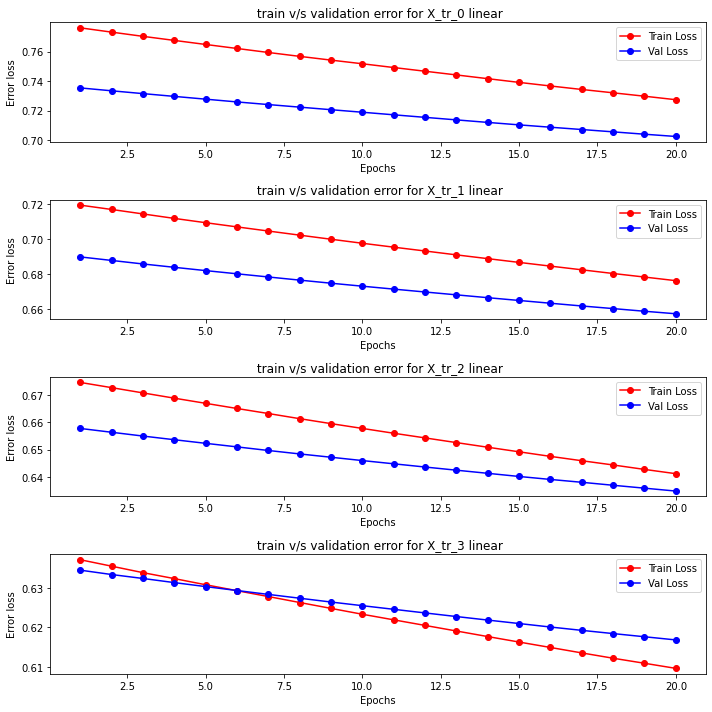

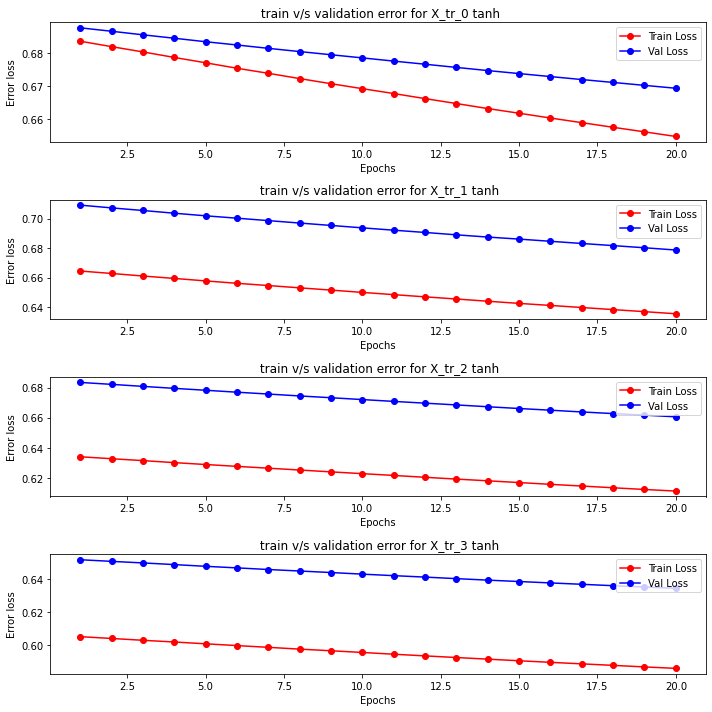

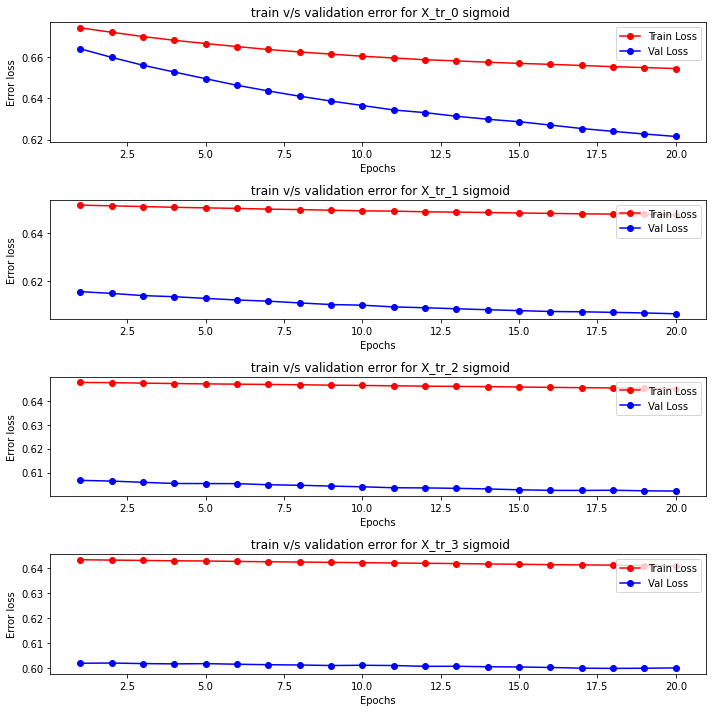

In [21]:
# verify the best activation function
activations = ['leakyRelu','linear','tanh','sigmoid']
learningRate = 2e-4

for fun in activations:
    model = modelANN(function=fun)
    model.compile(tf.keras.optimizers.SGD(learning_rate=learningRate),
                  loss = tf.keras.losses.BinaryCrossentropy(),
                  metrics = tf.keras.metrics.BinaryAccuracy())

    histories = []
    for i in range(4):
        val = f'X_val_{i}'    
        tr = f'X_tr_{i}'
        histories.append(model.fit(X[tr], y_tr, epochs=20, 
                        validation_data=(X[val],y_val),
                        verbose = 0))
    
    plotErrors(histories, name=fun)

- La mejor función de activación de acuerdo a cómo evolucionan las curvas de loss corresponde a la tangente hiperbólica, esto se aprecia en como la curva de validación empieza a converger al mismo valor que la curva de entrenamiento a lo largo de las 20 epochs de entrenamiento.

### Para la mejor funcion de activacion regularizacion L1
Se utilizan diferentes valores de rate para la regularizacion 

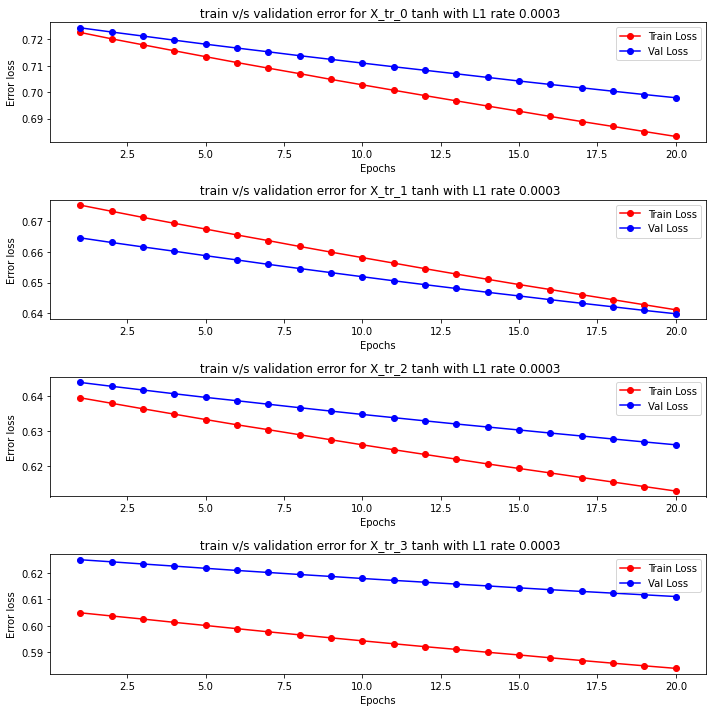

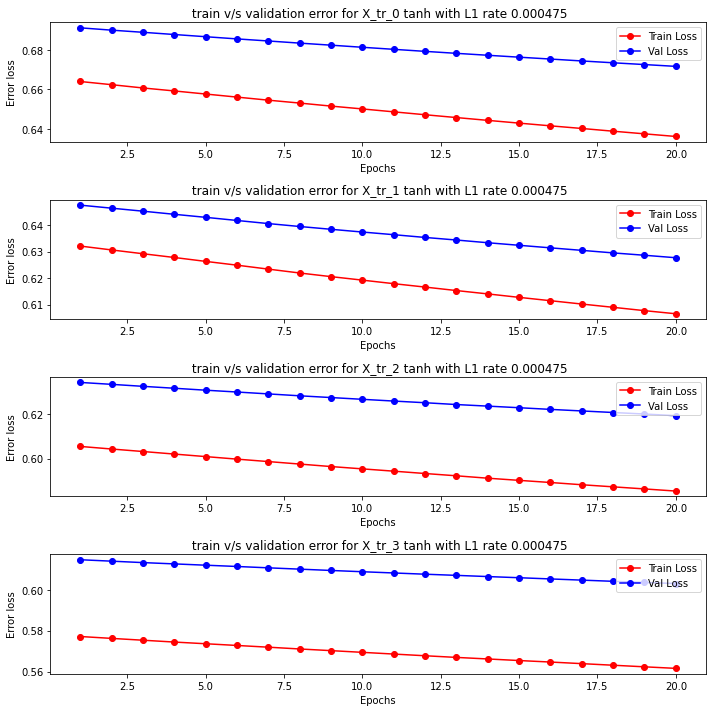

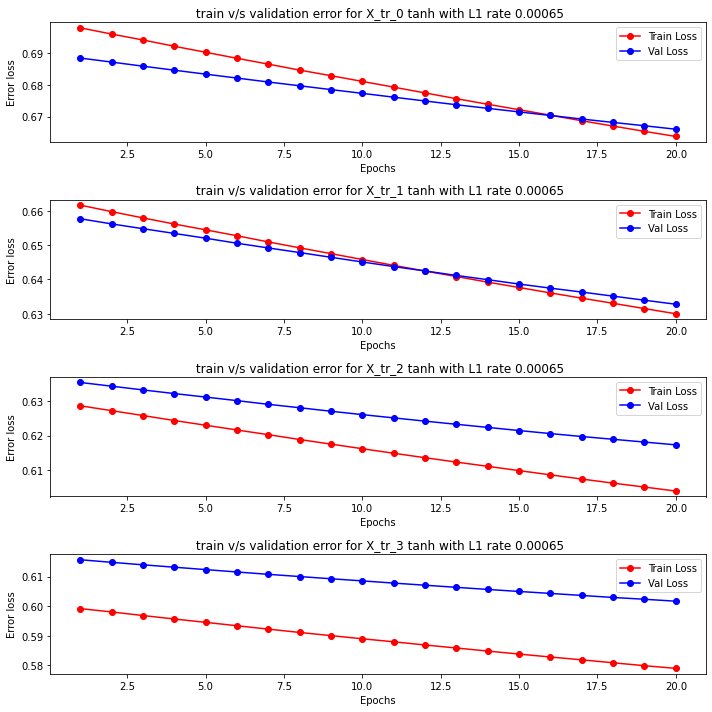

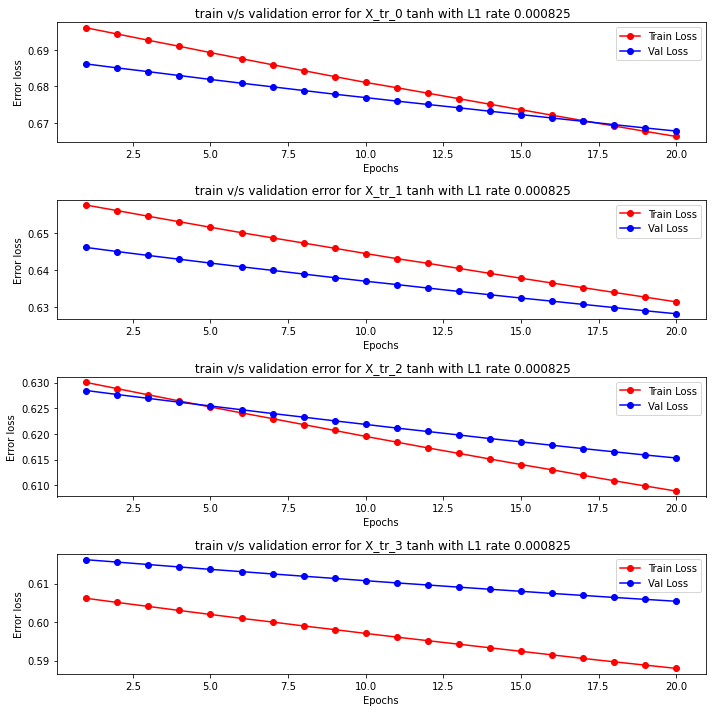

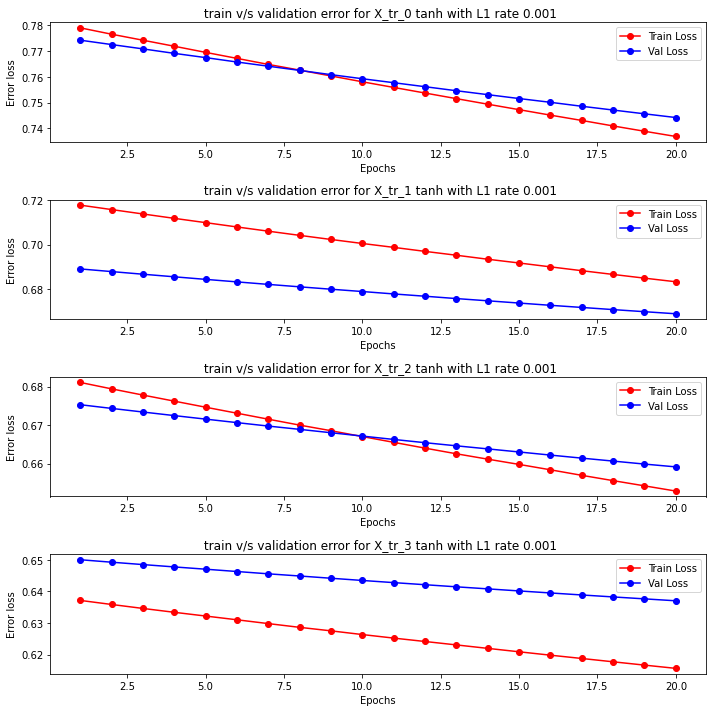

In [22]:
fun = 'tanh'
learningRate = 2e-4
rates = np.linspace(3e-4,1e-3,num=5)

for rate_ in rates:
    model = modelANN(function=fun, regularizer = 'l1', rate=rate_)
    model.compile(tf.keras.optimizers.SGD(learning_rate=learningRate),
                  loss = tf.keras.losses.BinaryCrossentropy(),
                  metrics = tf.keras.metrics.BinaryAccuracy())

    histories = []
    for i in range(4):
        val = f'X_val_{i}'    
        tr = f'X_tr_{i}'
        histories.append(model.fit(X[tr], y_tr, epochs=20, 
                                validation_data=(X[val],y_val),
                                verbose = 0))
    plotErrors(histories, name=f'{fun} with L1 rate {rate_}')

### Para la mejor funcion de activacion regularizacion L2
Se utilizan diferentes valores de rate para la regularizacion 

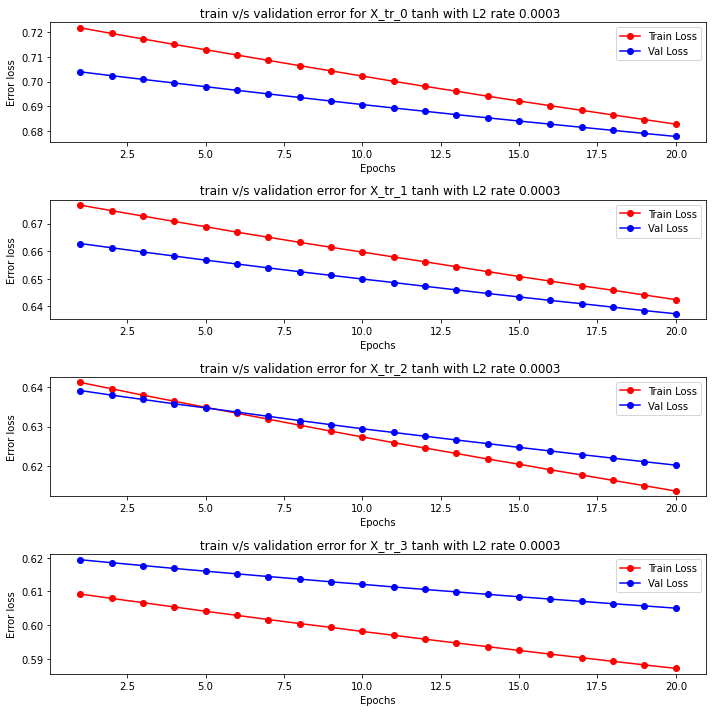

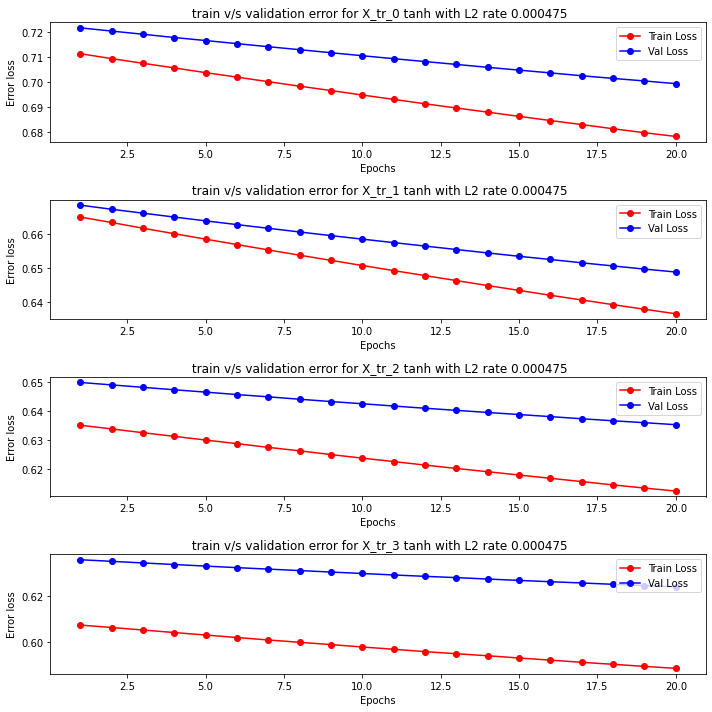

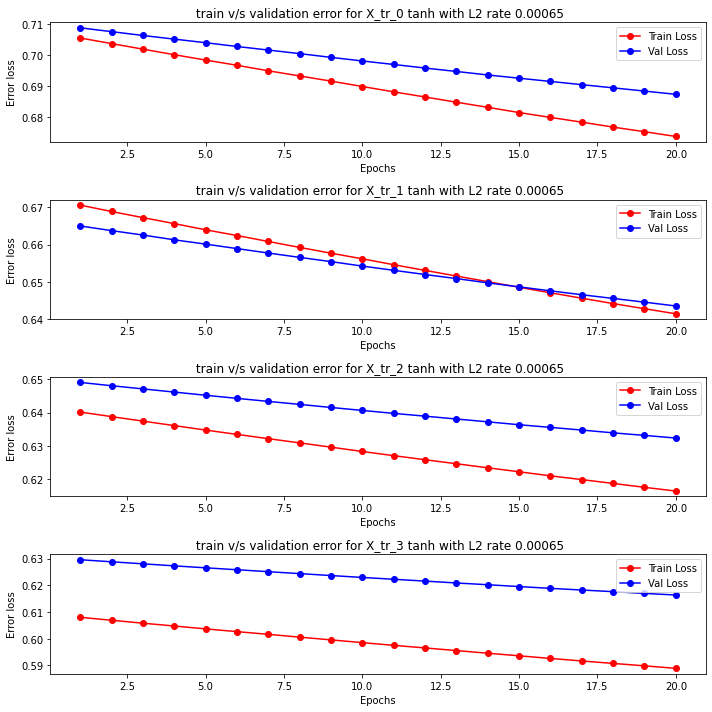

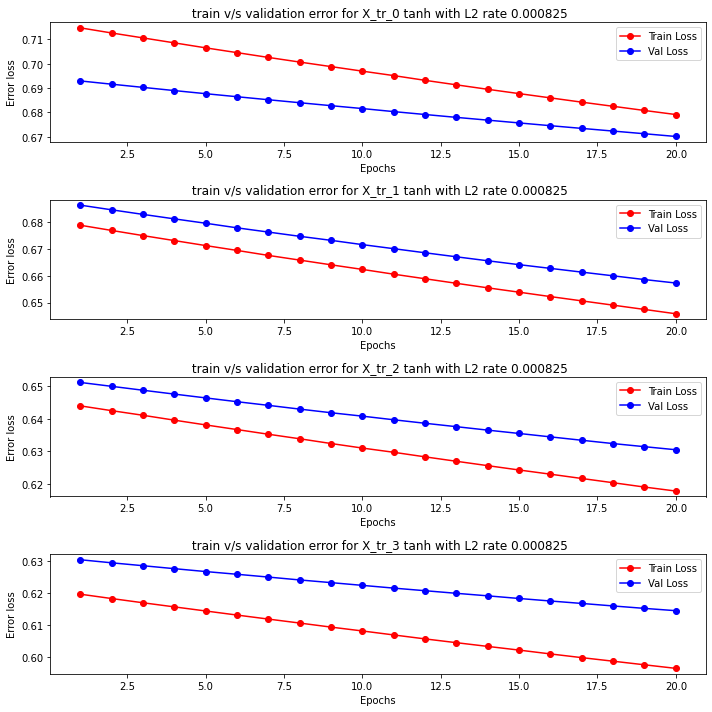

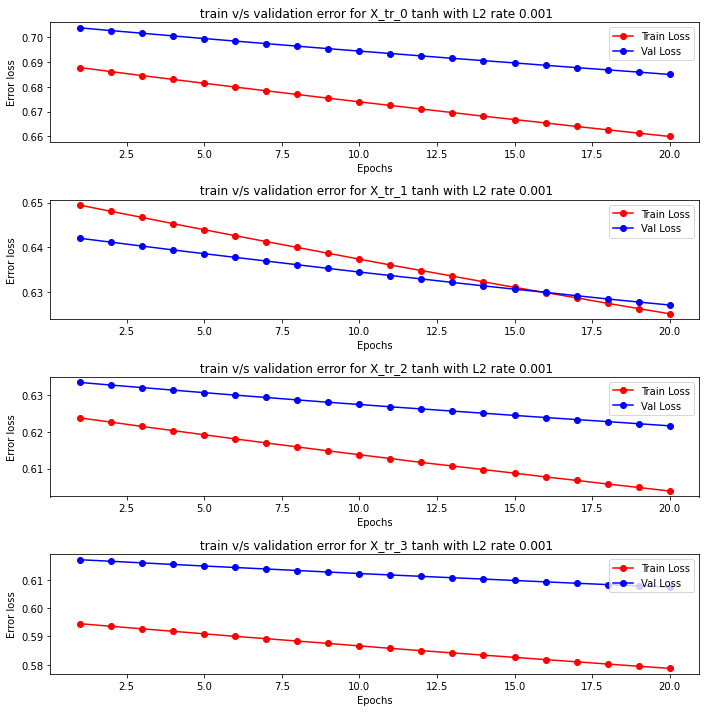

In [23]:
fun = 'tanh'
learningRate = 2e-4
rates = np.linspace(3e-4,1e-3,num=5)

for rate_ in rates:
    model = modelANN(function=fun, regularizer = 'l2', rate=rate_)
    model.compile(tf.keras.optimizers.SGD(learning_rate=learningRate),
                  loss = tf.keras.losses.BinaryCrossentropy(),
                  metrics = tf.keras.metrics.BinaryAccuracy())

    histories = []
    for i in range(4):
        val = f'X_val_{i}'    
        tr = f'X_tr_{i}'
        histories.append(model.fit(X[tr], y_tr, epochs=20, 
                                validation_data=(X[val],y_val),
                                verbose = 0))
        
    plotErrors(histories, name=f'{fun} with L2 rate {rate_}')

- ¿Qué ocurre si la regularización es muy alta o muy baja? 

### Se define un valor para la tasa de regularización de $4.75 e^{-4} $, y se aplica la regularización L2 a la capa de salida y luego a ambas capas. 



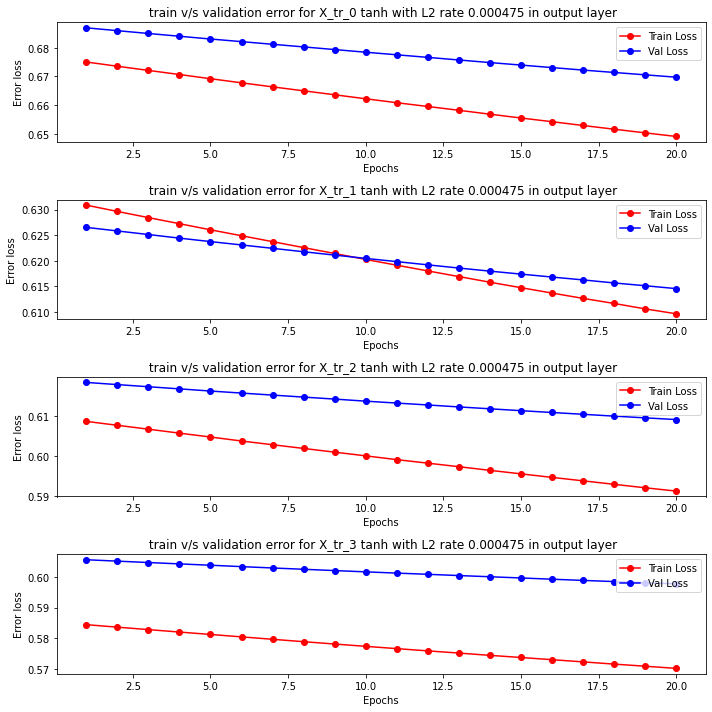

In [24]:
# Only output layer with L2
fun = 'tanh'
learningRate = 2e-4
rate_ = 4.75e-4

model = modelANN(function=fun, regularizer = 'l2', rate=rate_)
model.compile(tf.keras.optimizers.SGD(learning_rate=learningRate),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = tf.keras.metrics.BinaryAccuracy())

histories = []
for i in range(4):
    val = f'X_val_{i}'    
    tr = f'X_tr_{i}'
    histories.append(model.fit(X[tr], y_tr, epochs=20, 
                            validation_data=(X[val],y_val),
                            verbose = 0))
        
plotErrors(histories, name=f'{fun} with L2 rate {rate_} in output layer')

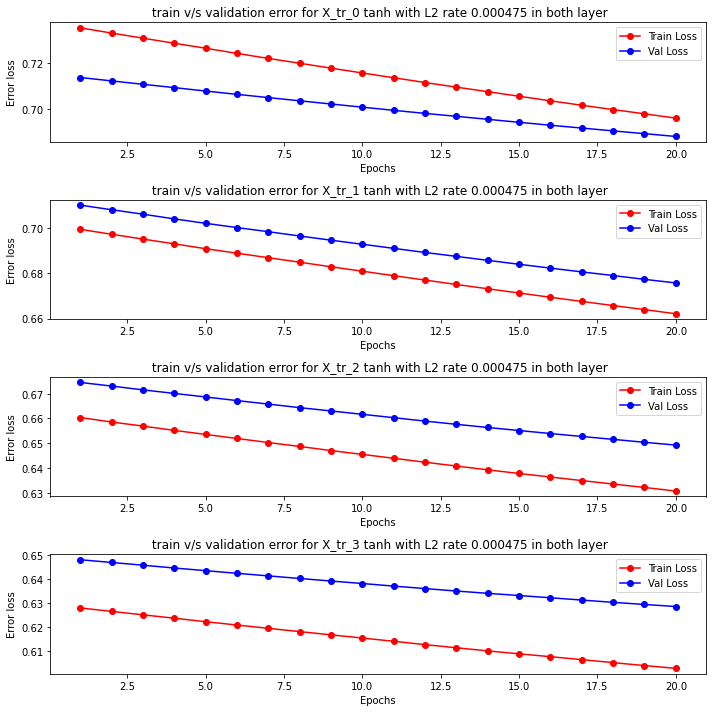

In [26]:
# Both layer with L2
fun = 'tanh'
learningRate = 2e-4
rate_ = 4.75e-4

model = modelANN(function=fun, regularizer = 'l2', rate=rate_, bothLayer=True)
model.compile(tf.keras.optimizers.SGD(learning_rate=learningRate),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = tf.keras.metrics.BinaryAccuracy())

histories = []
for i in range(4):
    val = f'X_val_{i}'    
    tr = f'X_tr_{i}'
    histories.append(model.fit(X[tr], y_tr, epochs=20, 
                            validation_data=(X[val],y_val),
                            verbose = 0))
        
plotErrors(histories, name=f'{fun} with L2 rate {rate_} in both layer')

- ¿Para qué se usan activaciones no lineales? 

Se usará una función no lineal debido a que le permite al el modelo adaptarse para trabajar con la mayor cantidad de datos, es decir, el modelo puede aprender y realizar tareas más complejas.

- ¿Le parece buena opción la activación sigmoidea para la capa oculta?

De acuerdo a las curvas de Loss no es la mejor funcion de activacion, esto se puede deber a que no es una funcion centrada en cero, como la tanh que dada las curvas de Loss parece ser la mejor opcion.

- ¿Cual es la intención de la regularización en general?

La regularización consiste en añadir una penalización a la función de coste. Esta penalización produce modelos más simples que generalizan mejor. Por lo tanto la intención de la regularización es aumentar la generalizacion del modelo.

- En particular, ¿Que restricción implicita imponen las regularizaciones $l$1 o $l$2 sobre los pesos de la capa en la cual se aplican? Apoyese de ecuaciones.

La regularización L1 reduce el coeficiente de la característica menos importante a cero, eliminando así algunas características. Por lo tanto, esto funciona bien para la selección de características en caso de que tengamos un gran número de características.

$ lossL1 = Erorr(y,\hat{y}) + λΣ_{i=1}^{N}|w_{i}| $

La regularización L2 añade la penalización a medida que aumenta la complejidad del modelo. El parámetro de regularización ($\lambda$) penaliza todos los parámetros excepto el intercepto para que el modelo generalice los datos y no se sobreajuste. 

$ lossL1 = Erorr(y,\hat{y}) + λΣ_{i=1}^{N}\beta_{i}^2 $